In [1]:
# resources

# https://github.com/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/llava_multi_modal_tesla_10q.ipynb
# https://llamahub.ai/l/multi_modal_llms/llama-index-multi-modal-llms-replicate?from=multi_modal_llms
# https://github.com/kb3k/master-thesis-embeddings

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from unstructured.partition.html import partition_html
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [4]:
from llama_index.readers.file import FlatReader
from pathlib import Path

reader = FlatReader()
docs_napoletana = reader.load_data(Path("napoletana.txt"))

In [5]:
from llama_index.core.node_parser import UnstructuredElementNodeParser

node_parser = UnstructuredElementNodeParser()

In [6]:
import os

REPLICATE_API_TOKEN = ""  # Your Relicate API token here
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

In [7]:
import openai

OPENAI_API_KEY = ""
openai.api_key = OPENAI_API_KEY  # add your openai api key here
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [8]:
import nest_asyncio
nest_asyncio.apply()

In [9]:
import os
import pickle

if not os.path.exists("napoletana_nodes.pkl"):
    raw_nodes_napoletana = node_parser.get_nodes_from_documents(docs_napoletana)
    pickle.dump(raw_nodes_2021, open("napoletana_nodes.pkl", "wb"))
else:
    raw_nodes_napoletana = pickle.load(open("napoletana_nodes.pkl", "rb"))

In [10]:
nodes_napoletana, objects_napoletana = node_parser.get_nodes_and_objects(raw_nodes_napoletana)

## Construct Retreivers

In [11]:
from llama_index.core import VectorStoreIndex

# construct top-level vector index + query engine
vector_index = VectorStoreIndex(nodes=nodes_napoletana, objects=objects_napoletana)
query_engine = vector_index.as_query_engine(similarity_top_k=2, verbose=True)

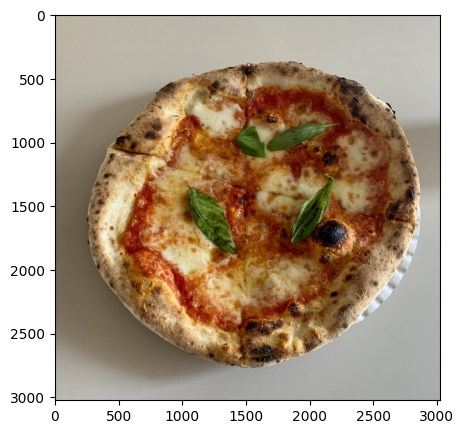

In [17]:
from PIL import Image
import matplotlib.pyplot as plt

imageUrl = "./napoletana.jpg"
image = Image.open(imageUrl).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

## Run LLaVa model using Replicate through LLama Index

In [18]:
from llama_index.multi_modal_llms.replicate import ReplicateMultiModal
from llama_index.core.schema import ImageDocument
from llama_index.multi_modal_llms.replicate.base import (
    REPLICATE_MULTI_MODAL_LLM_MODELS,
)

multi_modal_llm = ReplicateMultiModal(
    model=REPLICATE_MULTI_MODAL_LLM_MODELS["llava-13b"],
    max_new_tokens=200,
    temperature=0.1,
)


In [19]:
prompt = "which type of pizza factory is shown in the image? Is it deep dish or napoletana? How did you figure it out?"

llava_response = multi_modal_llm.complete(
    prompt=prompt,
    image_documents=[ImageDocument(image_path=imageUrl)],
)

prompt_template = "please provide relevant information about: "
rag_response = query_engine.query(prompt_template + llava_response.text)

In [20]:
print(rag_response)

The small, personal-sized pizza with a thin crust, cooked to a golden brown color and topped with cheese and basil leaves, aligns with the characteristics of a Neapolitan pizza. The thin crust and the use of fresh ingredients like basil leaves are indicative of a Neapolitan pizza, which is known for its simplicity and quality of ingredients. In contrast, deep dish pizza is typically characterized by a thicker crust and a heavier amount of toppings and cheese, setting it apart as a distinct type of pizza.


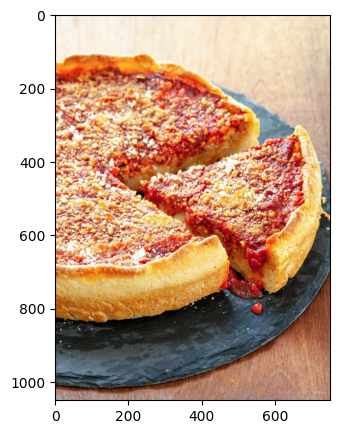

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

imageUrl = "./deepdish.jpg"
image = Image.open(imageUrl).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

In [22]:
llava_response = multi_modal_llm.complete(
    prompt=prompt,
    image_documents=[ImageDocument(image_path=imageUrl)],
)

In [23]:
prompt = "which type of pizza factory is shown in the image? Is it deep dish or napoletana? How did you figure it out?"

llava_response = multi_modal_llm.complete(
    prompt=prompt,
    image_documents=[ImageDocument(image_path=imageUrl)],
)

prompt_template = "please provide relevant information about: "
rag_response = query_engine.query(prompt_template + llava_response.text)

In [24]:
print(rag_response)

The key features that indicate it is a deep dish pizza include the thick crust, the generous amount of sauce, and the presence of cheese on top. Deep dish pizzas are known for their thick crust and abundant layers of toppings, which make them distinct from the thinner crust and more evenly distributed toppings of a Napoletana pizza. The fact that the pizza is cut into slices and placed on a plate also supports the idea that it is a deep dish pizza, as it is typically served in a pan or on a plate rather than being eaten directly from the pan.
